This python file is for CS 412 Spring 2022 Semester __Assignment 5 Problem 4__

I acknowledge that some of ideas are adopted from Cs440/ECE448 MP3: Netural Nets and Pytorch, and some codes are adopted from my ECE449 small project 2021 Fall semester, which I open source it at my github page. And since it is hard for me to use pytorch or tensorflow on my computer with M1 Pro chip locally, this notebook file is written and executed on __Kaggle__.

Author: __Ke Xu__ (NetID: kex5)

Date: __2022.04.30__

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

print("Kaggle successfully setup!")
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/412datasets/test_data.mat
/kaggle/input/412datasets/train_data.mat
Kaggle successfully setup!


In [2]:
# Import necessary libraries

import torch
torch.manual_seed(42) # set the random seed to be 42 as required

import torch.nn as nn # neural nets package

import scipy.io as scio # to load data

import math # for math functions
import matplotlib.pyplot as plt # for plot result

from tqdm.notebook import tqdm # to show the progress
from sklearn.metrics import classification_report, confusion_matrix # to print the report

print("Libraries successfully imported!")

Libraries successfully imported!


In [3]:
# Device configuration

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device successfully configured!")

Device successfully configured!


In [4]:
# Construct Neural Network

class Net(nn.Module): 
    def __init__(self):
        super(Net,self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(28*28, 32),  # fully-connected layer uses d = 784 = 28 × 28 input units, set hidden layer dimension to 32
            nn.ReLU(),        # use ReLU to activate as required
            nn.Linear(32, 10)  # since 10 classes, namely from 0 to 9
        )

    def forward(self, x):
        return self.layers(x)

print("Module successfully constructed!")

Module successfully constructed!


In [5]:
# Define three initilization methods as required


# Default initialization, which actually nothing special

def default_init(model):
    return

# Kaiming initialization, copied from https://pytorch-lightning.readthedocs.io/en/latest/notebooks/course_UvA-DL/03-initialization-and-optimization.html

def kaiming_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        elif name.startswith("layers.0"): 
            param.data.normal_(0, 1 / math.sqrt(param.shape[1]))
        else:
            param.data.normal_(0, math.sqrt(2) / math.sqrt(param.shape[1]))

# Equal Variance initialization, copied from https://pytorch-lightning.readthedocs.io/en/latest/notebooks/course_UvA-DL/03-initialization-and-optimization.html

def equal_var_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            param.data.normal_(std=1.0 / math.sqrt(param.shape[1]))
    return

print("Initialization methods successfully defined!")

Initialization methods successfully defined!


In [6]:
# Choose initilization models

def init_model(model, method):
    if method == 0:
        default_init(model)
        return
    elif method == 1:
        kaiming_init(model)
        return
    elif method == 2:
        equal_var_init(model)
        return
    
print("Initialization methods successfully chosen!")

Initialization methods successfully chosen!


In [7]:
# Train and test process

def Train_Test_Process(init_method):
    
    Train_Test_Result = [[],[],[],[]] # 3 dimension matrix to store loss, accuracy during the train, test process  
    
    for run in range(3): # run three times
        MLP = Net().to(device) # transfer model to device
        init_model(MLP, init_method)   # initialize the model with selected initialzation method
        loss_function = nn.CrossEntropyLoss() # define Loss and Optimizer
        optimizer = torch.optim.SGD(MLP.parameters(), lr=1e-2) # suggested learning rate is 0.01 for SGD, refered to https://pytorch.org/docs/stable/optim.html

        Train_Test_Epochs = [[],[],[],[]] # 2 dimension matrix to store loss, accuracy during the train, test process
        
        for epoch in range(40): # at least 40 epochs as required
            
            # Training process
            
            train_loss_sum = 0.0 
            train_acc_sum = 0.0
            train_batch_size = 0 # zero-initialize parameters
            
            for index, data in enumerate(train_loader):
                train_batch_size = index
                input, ground_truth = data
                optimizer.zero_grad()
                
                # Forward
                
                output = MLP.forward(input)           
                loss = loss_function(output, ground_truth) 
                
                # Backward
                
                loss.backward() # back propogation
                
                # Optimize
                
                optimizer.step() # update paramters
                
                # Train Evaluation
                
                train_loss_sum += loss.item()
                train_acc_sum += torch.eq(torch.argmax(output, dim=1), ground_truth).sum()

            Train_Test_Epochs[0].append(train_loss_sum/train_batch_size) # take the mean
            Train_Test_Epochs[2].append(train_acc_sum/train_size)
            
            # Testing process
            
            test_loss_sum = 0.0
            test_acc_sum = 0.0
            test_batch_size = 0 # zero-initialize parameters
            
            for index, data in enumerate(test_loader):
                test_batch_size = index
                input, ground_truth = data
                
                # Forward
                
                output = MLP.forward(input)
                
                # Test Evaluation
                
                test_loss_sum += loss_function(output, ground_truth).item()
                test_acc_sum += torch.eq(torch.argmax(output, dim=1), ground_truth).sum()

            Train_Test_Epochs[1].append(test_loss_sum/test_batch_size) # take the mean
            Train_Test_Epochs[3].append(test_acc_sum/test_size)
        
        Train_Test_Result[0].append(Train_Test_Epochs[0])
        Train_Test_Result[1].append(Train_Test_Epochs[1])
        Train_Test_Result[2].append(Train_Test_Epochs[2])
        Train_Test_Result[3].append(Train_Test_Epochs[3])
        
    return Train_Test_Result[0], Train_Test_Result[1], Train_Test_Result[2], Train_Test_Result[3]

print("Training and testing process successfully defined!")

Training and testing process successfully defined!


In [8]:
def plot(title="Plot Title"):
    xlabel = np.linspace(1,40,num=40)
    
    plt.figure(figsize=(10*2,6*2))
    plt.suptitle(title)
    
    plt.subplot(221)
    plt.title("Training loss curves w.r.t. Training epochs")
    plt.errorbar(x=xlabel,y=np.mean(Train_Loss,axis=0),yerr=np.std(Train_Loss,axis=0))
    plt.ylabel("Training loss")
    plt.xlabel("Training epochs")
    
    plt.subplot(222)
    plt.title("Training accuracy w.r.t. Training epochs")
    plt.errorbar(x=xlabel,y=np.mean(Train_Accuracy,axis=0),yerr=np.std(Train_Accuracy,axis=0))
    plt.ylabel("Training accuracy")
    plt.xlabel("Training epochs")

    
    plt.subplot(223)
    plt.title("Testing loss curves w.r.t. Training epochs")
    plt.errorbar(x=xlabel,y=np.mean(Test_Loss,axis=0),yerr=np.std(Test_Loss,axis=0))
    plt.ylabel("Testing loss")
    plt.xlabel("Training epochs")
    
    plt.subplot(224)
    plt.title("Testing accuracy w.r.t. Training epochs")
    plt.errorbar(x=xlabel,y=np.mean(Test_Accuracy,axis=0),yerr=np.std(Test_Accuracy,axis=0))
    plt.ylabel("Testing accuracy")
    plt.xlabel("Training epochs")
    
print("Plot function successfully defined!")

Plot function successfully defined!


In [9]:
# Load data

train = scio.loadmat("../input/412datasets/train_data.mat")
test = scio.loadmat("../input/412datasets/test_data.mat")

train_data = torch.FloatTensor(train['X'])
test_data = torch.FloatTensor(test['X'])
train_label = torch.FloatTensor(train['Y'])
test_label = torch.FloatTensor(test['Y'])

train_dataset = list(zip(train_data, map(int,train_label)))
test_dataset = list(zip(test_data, map(int,test_label)))

train_size = train_data.shape[0] # size of training set
test_size = test_data.shape[0]   # size of testing set

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256) # recommended batch size would be 256 for training
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000) # recommended batch size 1000 for testing

print("Data successfully loaded!")

Data successfully loaded!


The training and testing process begins.
The training and testing process ends.


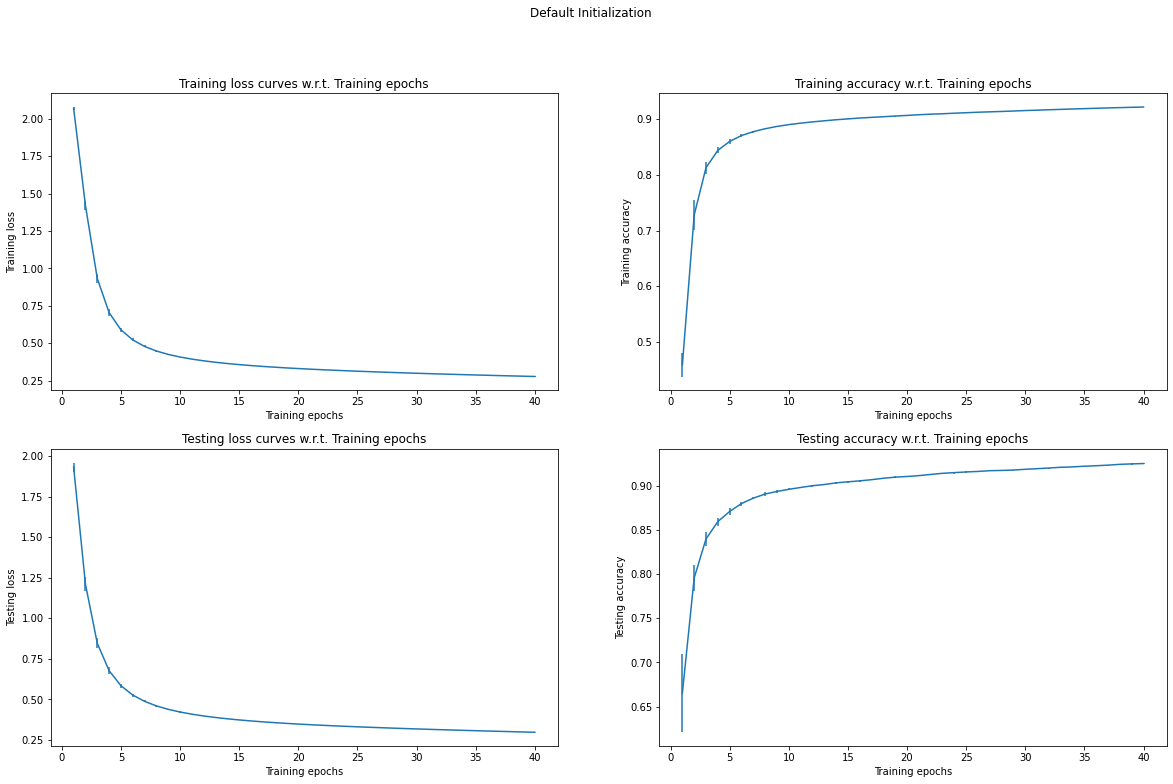

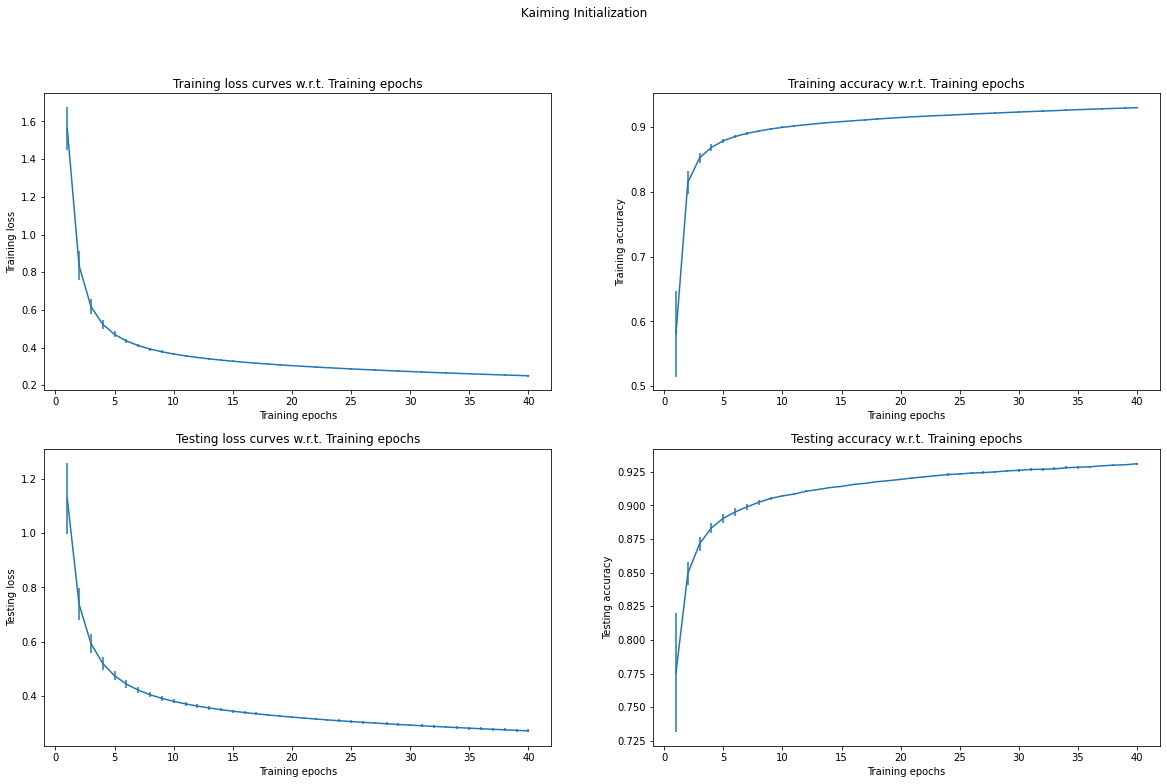

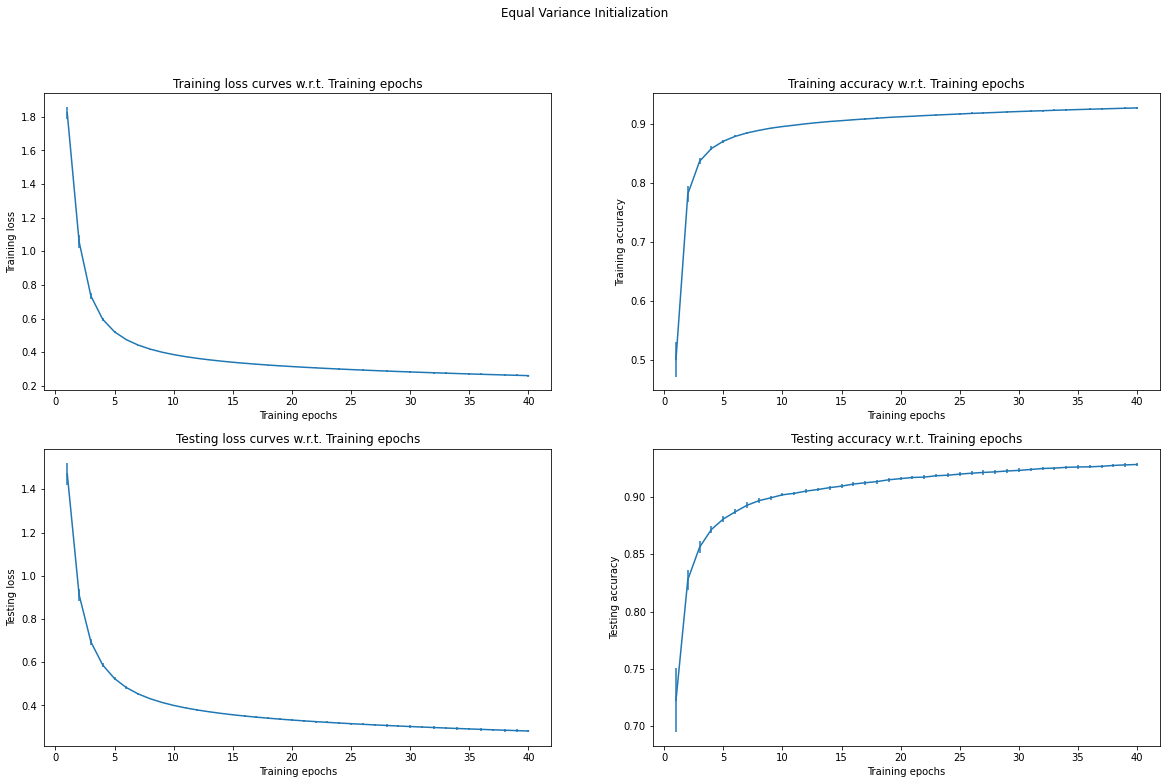

In [10]:
# The main body

print("The training and testing process begins.")

init_method = ['Default Initialization','Kaiming Initialization','Equal Variance Initialization']

for channel in range(3): # choose among three initialization methods
    
    Train_Loss,Test_Loss,Train_Accuracy,Test_Accuracy = Train_Test_Process(init_method=channel) # train and test
    plot(title=init_method[channel]) # plot results as required

print("The training and testing process ends.")